In [1]:
%load_ext autoreload
%autoreload 2

In [46]:
import src
import pandas as pd
import numpy as np
import lightgbm as lgb
import joblib

pd.set_option('display.max_rows', None)
import matplotlib.pyplot as plt
import logging
src.logging_config.setup_logging(logging.INFO)

Logging has been configured.


# Load Config file

In [47]:
CONFIG = src.util.load_config()

2024-10-03 02:58:38,856 - src.util - INFO - Loaded CONFIG:
{
    "pred_days": 7,
    "pred_date": "2021-07-01",
    "features": [
        "loc_roll7_mean",
        "loc_roll14_mean",
        "loc_roll28_mean",
        "loc_roll56_mean",
        "loc_roll7_std",
        "loc_roll14_std",
        "loc_roll28_std",
        "loc_roll56_std",
        "location_duration_days",
        "population",
        "weekday",
        "is_sunday",
        "loc_lag0",
        "loc_lag1",
        "loc_lag2",
        "loc_lag3",
        "loc_lag4",
        "loc_lag5",
        "loc_lag6",
        "new_vaccinated_rate",
        "cumsum_vaccinated_rate",
        "loc_rain_roll7_sum",
        "loc_rain_roll14_sum",
        "loc_rain_roll28_sum",
        "loc_rain_roll56_sum",
        "location_key_encoded",
        "latitude",
        "longitude",
        "relative_humidity",
        "loc_same_weekday_roll2_mean",
        "loc_same_weekday_roll3_mean",
        "loc_same_weekday_roll4_mean",
        "loc_same

# Feature Pipeline

In [7]:
%%time

covid_data_loader = src.features.CovidDataLoader(level=1)
target_creator = src.features.TargetCreator(shift_day=CONFIG["pred_days"])
weekday = src.features.Weekday()
is_sunday = src.features.IsSunday()
location_rolling_mean = src.features.LocationRollingMean(shift_day=0, rolling_days=[7, 14, 28, 56])
location_rolling_std = src.features.LocationRollingStd(shift_day=0, rolling_days=[7, 14, 28, 56])
location_same_weekday_rolling_mean = src.features.LocationSameWeekDayRollingMean(shift_day=0, rolling_days=[2,3,4,5,6,7,8])
location_duration_days = src.features.LocationDurationDays()
location_lag = src.features.LocationLag(lag_days=[0,1,2,3,4,5,6])
location_rain_rolling_sum = src.features.LocationRainRollingSum(rolling_days=[7, 14, 28, 56])
country_population = src.features.CountryPopulation()
country_rolling_mean = src.features.CountryRollingMean(shift_day=0, rolling_days=[7, 14, 28, 56])
country_rolling_std = src.features.CountryRollingStd(shift_day=0, rolling_days=[7, 14, 28, 56])
distance_from_city = src.features.DistanceFromCity()
temperature_rolling_mean = src.features.TemperatureRollingMean(shift_day=0, rolling_days=[7, 14, 28, 56])
temperature_rolling_std = src.features.TemperatureRollingStd(shift_day=0, rolling_days=[7, 14, 28, 56])
relative_humidity_rolling_mean = src.features.RelativeHumidityRollingMean(shift_day=0, rolling_days=[7, 14, 28, 56])
relative_humidity_rolling_std = src.features.RelativeHumidityRollingStd(shift_day=0, rolling_days=[7, 14, 28, 56])
vaccinated_rate = src.features.VaccinatedRate()
encoder = src.features.MinDateEncoder()
ratio_feature = src.features.RatioFeature()
missing_value = src.features.MissingValue(features=CONFIG['features'])

pipeline = [covid_data_loader, 
            target_creator,    
            vaccinated_rate,
            weekday,
            is_sunday,
            location_rolling_mean,
            location_rolling_std,
            location_same_weekday_rolling_mean,
            location_duration_days,
            location_lag,
            location_rain_rolling_sum,
            country_population,
            country_rolling_mean,
            country_rolling_std,
            encoder,
            distance_from_city,
            temperature_rolling_mean,
            temperature_rolling_std,
            relative_humidity_rolling_mean,
            relative_humidity_rolling_std,
            ratio_feature,
            missing_value,
           ]
df = None
for t in pipeline:
    if hasattr(t, 'fit'):
        t.fit(df)
    df = t.transform(df)

2024-10-03 01:57:30,663 - src.features - INFO - ---- Covid Data Loader --------
2024-10-03 01:57:30,665 - src.features - INFO -   loading dataset ...
2024-10-03 01:57:35,691 - src.features - INFO -   cleaning dataset ...
2024-10-03 01:57:39,458 - src.features - INFO -   sorting dataset by location and date...
2024-10-03 01:57:39,768 - src.features - INFO - ---- Target Creator (new_confirmed / population * 100) --------
2024-10-03 01:57:39,769 - src.features - INFO -  shifting -7 day(s)...
2024-10-03 01:57:39,771 - src.util - INFO - truncating target outliers ...
2024-10-03 01:57:40,180 - src.features - INFO - ---- Vaccine Rate --------
2024-10-03 01:57:40,241 - src.features - INFO - ---- Week day --------
2024-10-03 01:57:40,270 - src.features - INFO - ---- Is Sunday--------
2024-10-03 01:57:40,299 - src.features - INFO - ---- Location Rolling Mean Feature --------
2024-10-03 01:57:40,300 - src.features - INFO - rolling 7 days -> loc_roll7_mean
2024-10-03 01:57:40,720 - src.features - 

CPU times: user 49.2 s, sys: 4.26 s, total: 53.5 s
Wall time: 55.5 s


# CV Tuning
Model performance is decided by time series CV score and std

In [74]:
def compute_cv_score(df, CONFIG, tuning_param):
    cv_score = {}
    # Cross Validation Score (7-day shift)
    for i, cv_date in enumerate(["2021-06-03", "2021-06-10", "2021-06-17", "2021-06-24"]):
        # train / test split
        cv_train_df, cv_test_df = src.util.train_test_split(df, 
                                                            ref_date=cv_date, 
                                                            pred_days=CONFIG["pred_days"],
                                                            gap_days=CONFIG["pred_days"])

        # train
        lgb_model = src.models.LGBRollingForecastModel(features = CONFIG["features"], 
                                                       lgb_params = lgb_params, 
                                                       num_boost_round=3000, 
                                                       importance_coverage=tuning_param['importance_coverage'],
                                                       verbose=-1
                                                      )
        lgb_model.fit(cv_train_df)
        
        # compute score
        cv_pred_df = lgb_model.transform(cv_test_df)
        cv_score[f'cv{i}'] = src.util.score(cv_pred_df['population'], cv_pred_df['prediction'], cv_pred_df['target'])
        
    mu = float(np.mean(list(cv_score.values())))
    std = float(np.std(list(cv_score.values())))
    cv_score['mean'] = mu
    cv_score['std'] = std
    return cv_score


In [75]:
# Hyper parameter Tuning Demo
tuning_df = pd.DataFrame(columns=['importance_coverage', 'cv_score_mean', 'cv_store_std'])

# Grid search
for i, importance_coverage in enumerate([0.8, 0.85, 0.9, 0.95, 1.1]):
    cv_score = compute_cv_score(df, CONFIG, {"importance_coverage": importance_coverage})
    tuning_df.loc[i] = [importance_coverage, cv_score['mean'], cv_score['std']]

display(tuning_df)

2024-10-02 15:13:58,059 - src.util - INFO - train / test split: 
  gap days = 7
  2020-05-01 <= train <= 2021-05-26
  2021-05-27 <= test <= 2021-06-02
2024-10-02 15:13:58,178 - src.util - INFO - train size: 199272; test_size: 4856
2024-10-02 15:13:58,180 - src.models - INFO - ---- LightGBM Rolling Forecast Model fitting --------
2024-10-02 15:13:58,181 - src.models - INFO -     round 1: fit all 58 features ...
2024-10-02 15:14:57,992 - src.models - INFO -     round 2: fit top 40 features ...
2024-10-02 15:15:46,489 - src.models - INFO - ---- LightGBM Rolling Forecast Model transform --------
2024-10-02 15:15:46,865 - src.util - INFO - train / test split: 
  gap days = 7
  2020-05-01 <= train <= 2021-06-02
  2021-06-03 <= test <= 2021-06-09
2024-10-02 15:15:46,984 - src.util - INFO - train size: 204128; test_size: 4895
2024-10-02 15:15:46,997 - src.models - INFO - ---- LightGBM Rolling Forecast Model fitting --------
2024-10-02 15:15:46,999 - src.models - INFO -     round 1: fit all 58 

,importance_coverage,cv_score_mean,cv_store_std
0,0.80,0.002215,0.000269
1,0.85,0.002202,0.000271
2,0.90,0.002193,0.000282
3,0.95,0.002185,0.000269
4,1.10,0.002205,0.000277


In [76]:
tuning_df.to_csv("./scores/rolling_model.csv", index=False)

# Prediction

In [26]:
train_df, test_df = src.util.train_test_split(df, 
                                              ref_date=CONFIG["pred_date"], 
                                              pred_days=CONFIG["pred_days"],
                                              gap_days=CONFIG["pred_days"]
                                             )

2024-10-03 02:06:47,127 - src.util - INFO - train / test split: 
  gap days = 7
  2020-05-01 <= train <= 2021-06-23
  2021-06-24 <= test <= 2021-06-30
2024-10-03 02:06:47,237 - src.util - INFO - train size: 190600; test_size: 3779


In [31]:
models = []
for seed in [10, 20, 30]:
    lgb_model = src.models.LGBRollingForecastModel(features = CONFIG["features"], 
                                                   lgb_params = CONFIG["lgb_params"], 
                                                   num_boost_round=3000, 
                                                   importance_coverage=0.95,
                                                   seed=seed,
                                                   verbose=0
                                                  )
    models.append(lgb_model)

averaged_model = src.models.AveragedModel(models=models)
averaged_model.fit(train_df)
pred_df = averaged_model.transform(test_df)
score = src.util.score(pred_df['population'], pred_df['prediction'], pred_df['target'])
print(f"test score = {score:.4f}")

2024-10-03 02:08:31,835 - src.models - INFO - ---- Averaged Model fitting --------
2024-10-03 02:08:31,837 - src.models - INFO -     fitting model 0
2024-10-03 02:08:31,838 - src.models - INFO - ---- LightGBM Rolling Forecast Model fitting --------
2024-10-03 02:08:31,839 - src.models - INFO -     round 1: fit all 59 features ...
2024-10-03 02:09:31,082 - src.models - INFO -     round 2: fit top 52 features ...
2024-10-03 02:10:26,012 - src.models - INFO -     fitting model 1
2024-10-03 02:10:26,013 - src.models - INFO - ---- LightGBM Rolling Forecast Model fitting --------
2024-10-03 02:10:26,014 - src.models - INFO -     round 1: fit all 59 features ...
2024-10-03 02:11:25,608 - src.models - INFO -     round 2: fit top 52 features ...
2024-10-03 02:12:20,841 - src.models - INFO -     fitting model 2
2024-10-03 02:12:20,843 - src.models - INFO - ---- LightGBM Rolling Forecast Model fitting --------
2024-10-03 02:12:20,844 - src.models - INFO -     round 1: fit all 59 features ...
2024

test score = 0.0022


In [32]:
averaged_model.feature_importance_df.sort_values(['feature_importance'], ascending=False)
        

,feature_name,feature_importance_0,feature_importance_1,feature_importance_2,feature_importance
30,location_duration_days,11978,11986,11884,11949
31,location_key_encoded,6507,6570,6514,6530
33,population,6149,6265,6537,6317
2,distance_from_city,6235,6054,6181,6156
4,latitude,6064,6057,5819,5980
5,loc_lag0,6020,5653,5818,5830
47,temperature_roll56_mean,5532,5352,5733,5539
14,loc_rain_roll56_sum,5221,5144,5289,5218
3,distance_from_cn_hb,5005,5194,5057,5085
32,longitude,4903,4788,5053,4914


### Save prediction &  model

In [33]:
pred_df.to_csv("./predictions/rolling_model.csv", index=False)

In [34]:
src.util.save_model(averaged_model, "lgb_rolling_forcast_model.joblib")

2024-10-03 02:15:46,895 - src.util - INFO - Saving model to ./models/lgb_rolling_forcast_model.joblib


# Visualization

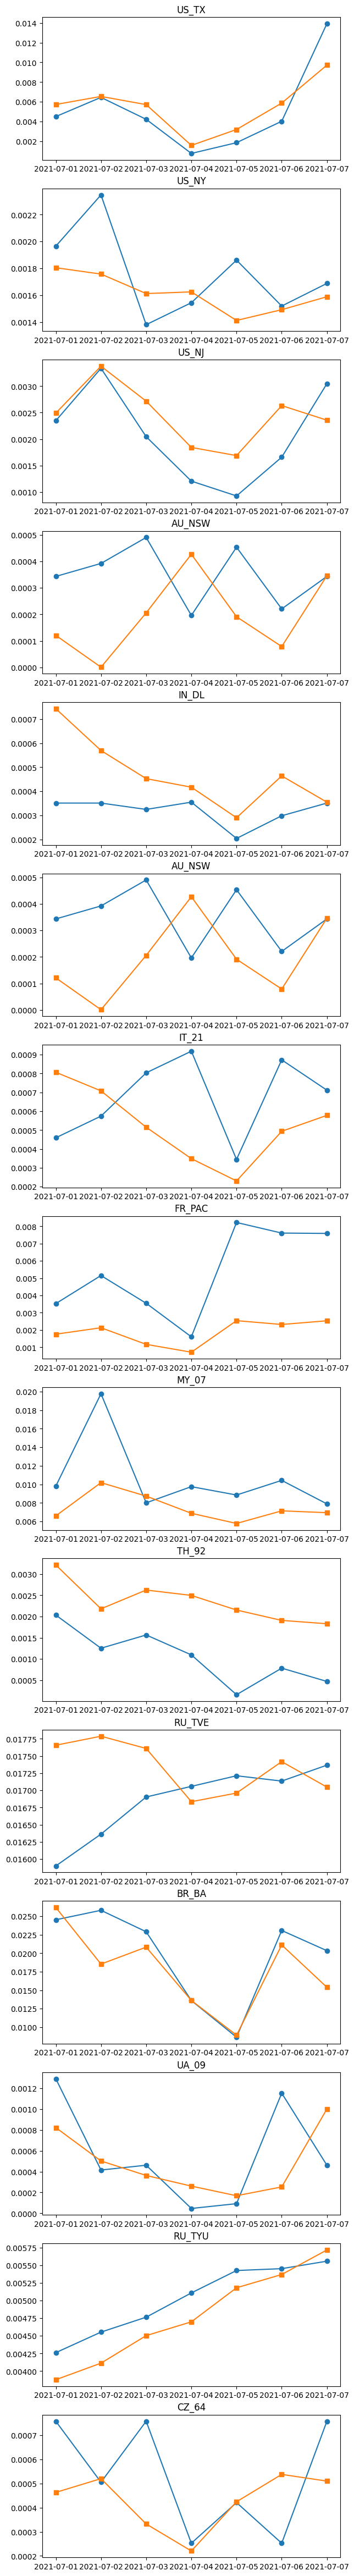

In [43]:
selected_locations = ['US_TX', 'US_NY', 'US_NJ', 'AU_NSW', 'IN_DL', 'AU_NSW', 'IT_21']
random_loations = np.random.choice(pred_df['location_key'].unique(), 8).tolist()
locations = selected_locations + random_loations
location_cnt = len(locations)
fig, ax = plt.subplots(location_cnt, 1, figsize=(7, 4*location_cnt))
for i, location_key in enumerate(locations):
    tmp = pred_df[pred_df['location_key']==location_key]
    ax[i].plot(tmp['target_date'], tmp['target'], marker='o')
    ax[i].plot(tmp['target_date'], tmp['prediction'], marker='s')
    ax[i].set_title(location_key)